<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [31]:
# yahoo finance
import yfinance as yf
# personal scripts
import wrangle as w
# prophet model
from prophet import Prophet
# dataframes & matrices
import pandas as pd
import numpy as np
# stats and eval
from sklearn.metrics import mean_squared_error
from math import sqrt
# viz
import seaborn as sns
import matplotlib.pyplot as plt
# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid


In [32]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Acquiring Eth-USD df

In [33]:
eth_usd = yf.Ticker("eth-usd")

In [34]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1732.4095
7,open,1732.4095
8,dayLow,1717.4844
9,dayHigh,1739.666


In [35]:
eth = eth_usd.history(period='5mo',interval='1h')

In [36]:
eth.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-02 10:00:00+00:00,1732.112305,1733.581909,1731.172607,1732.154907,0,0.0,0.0
2023-10-02 11:00:00+00:00,1732.249146,1733.944092,1725.881592,1727.088135,59260416,0.0,0.0
2023-10-02 12:00:00+00:00,1726.468140,1733.509277,1726.022705,1731.929810,165249536,0.0,0.0
2023-10-02 13:00:00+00:00,1731.623901,1731.623901,1721.685913,1726.538696,121533952,0.0,0.0
2023-10-02 14:00:00+00:00,1727.216309,1727.216309,1719.980591,1720.577148,41272320,0.0,0.0


In [37]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


# Preparing Eth

In [38]:
eth = w.prepare_eth(eth)

In [39]:
X = eth.drop(columns=['close'])
y = eth.close

# Exploring Eth

<Axes: xlabel='Datetime'>

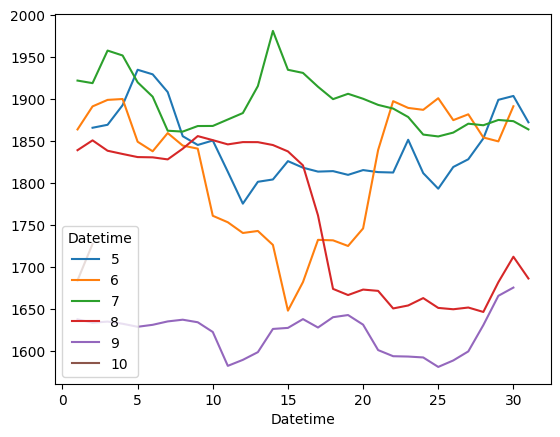

In [40]:
eth.groupby([eth.index.day,eth.index.month])['close'].mean().unstack().plot()

<Axes: xlabel='Datetime'>

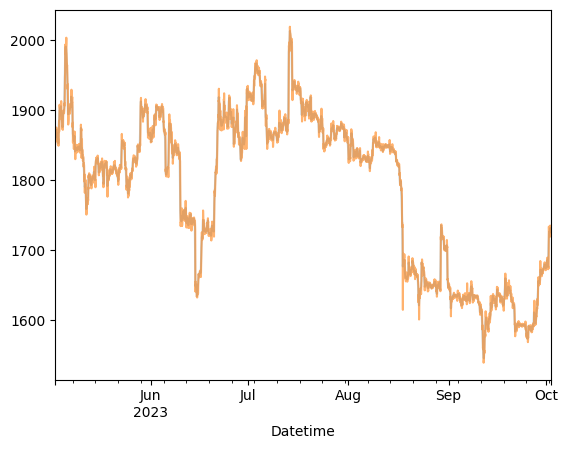

In [41]:
eth.close.resample('4h').mean().plot(alpha=.3)
eth.close.resample('1h').mean().plot(alpha=.6)

# Split

In [42]:
train_size = int(eth.shape[0] * .6)
test_size = int(eth.shape[0] * .4)

test_end_index = train_size + test_size


In [43]:
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

In [44]:
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (2203,), Test shape: (1469,) , Eth shape: (3673, 9)


In [ ]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Prophet model has been fit and can now be used to make predictions.

In [45]:
m = Prophet(yearly_seasonality=False, changepoint_prior_scale=.1)

In [46]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [47]:
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')

In [48]:
model = m.fit(train_model)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ug7gjj4/5si7xbc2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ug7gjj4/em2rnjfm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64850', 'data', 'file=/tmp/tmp0ug7gjj4/5si7xbc2.json', 'init=/tmp/tmp0ug7gjj4/em2rnjfm.json', 'output', 'file=/tmp/tmp0ug7gjj4/prophet_modelgsdvbhvs/prophet_model-20231002141014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [49]:
testmodel = m.predict(test_model)

# Forecast DF with predicted values

In [50]:
future = model.make_future_dataframe(periods=4, freq='H')
forecast = model.predict(future)

In [25]:
# future_test = testmodel.make_future_dataframe(periods=4, freq='H')
# forecast_test = testmodel.predict(future_test)

## Exploring Forecast

In [51]:
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-05-02 14:00:00,1848.685351,-1.104799,-2.157051,1845.423500
1,2023-05-02 15:00:00,1849.919421,-0.412325,-1.760908,1847.746188
2,2023-05-02 16:00:00,1851.153491,0.273300,-0.676061,1850.750730
3,2023-05-02 17:00:00,1852.387561,0.944613,0.454996,1853.787169
4,2023-05-02 18:00:00,1853.621631,1.594258,1.032452,1856.248341
...,...,...,...,...,...
2202,2023-08-02 08:00:00,1840.368615,5.246667,-0.371955,1845.243326
2203,2023-08-02 09:00:00,1840.162486,4.998926,-0.029904,1845.131508
2204,2023-08-02 10:00:00,1839.956357,4.684759,0.245113,1844.886229
2205,2023-08-02 11:00:00,1839.750229,4.307845,0.046181,1844.104254


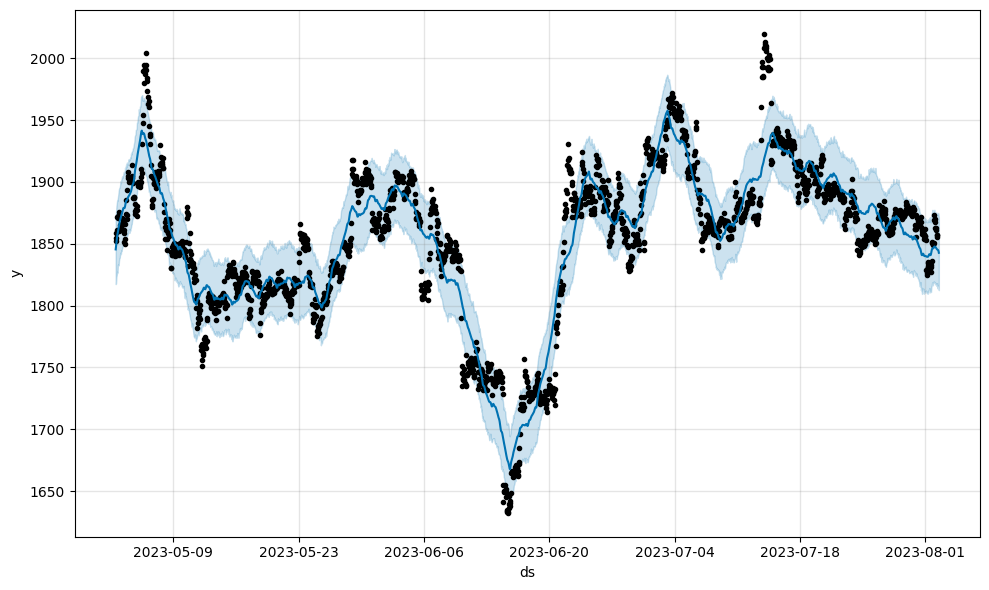

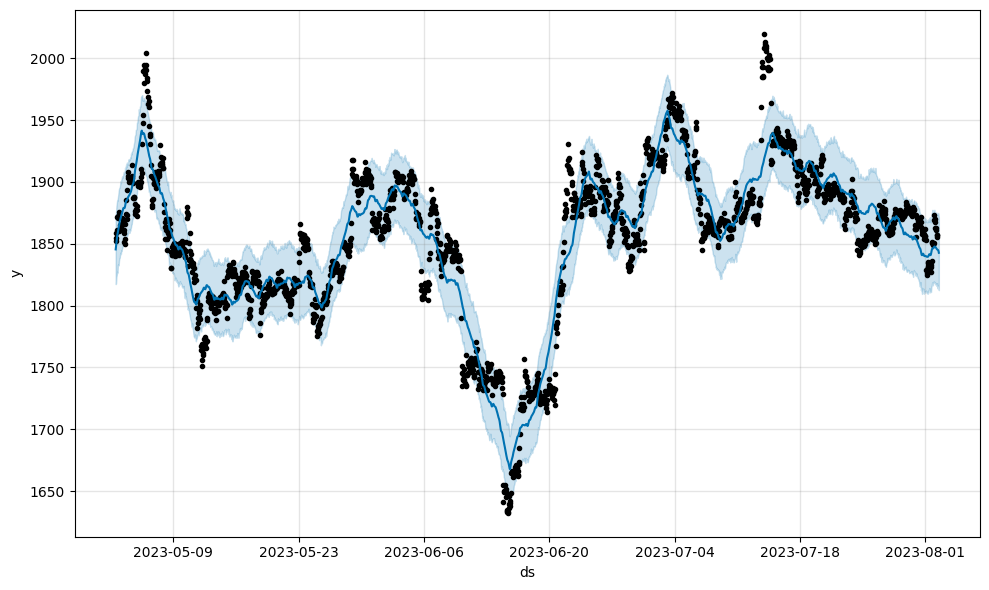

In [52]:
m.plot(forecast)

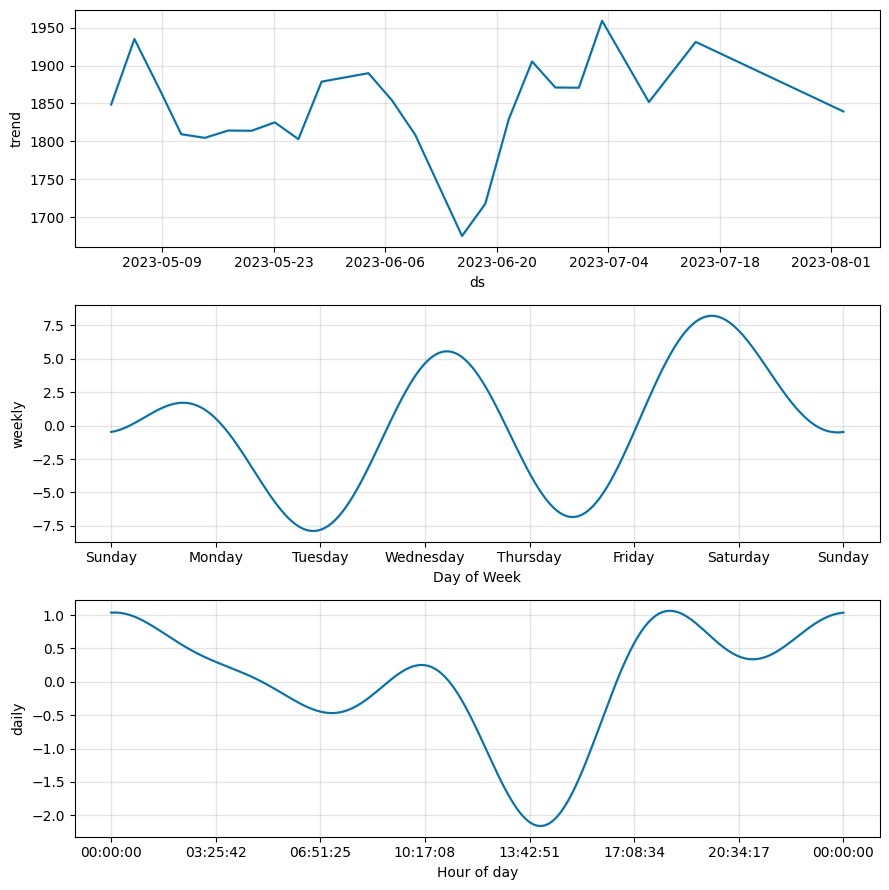

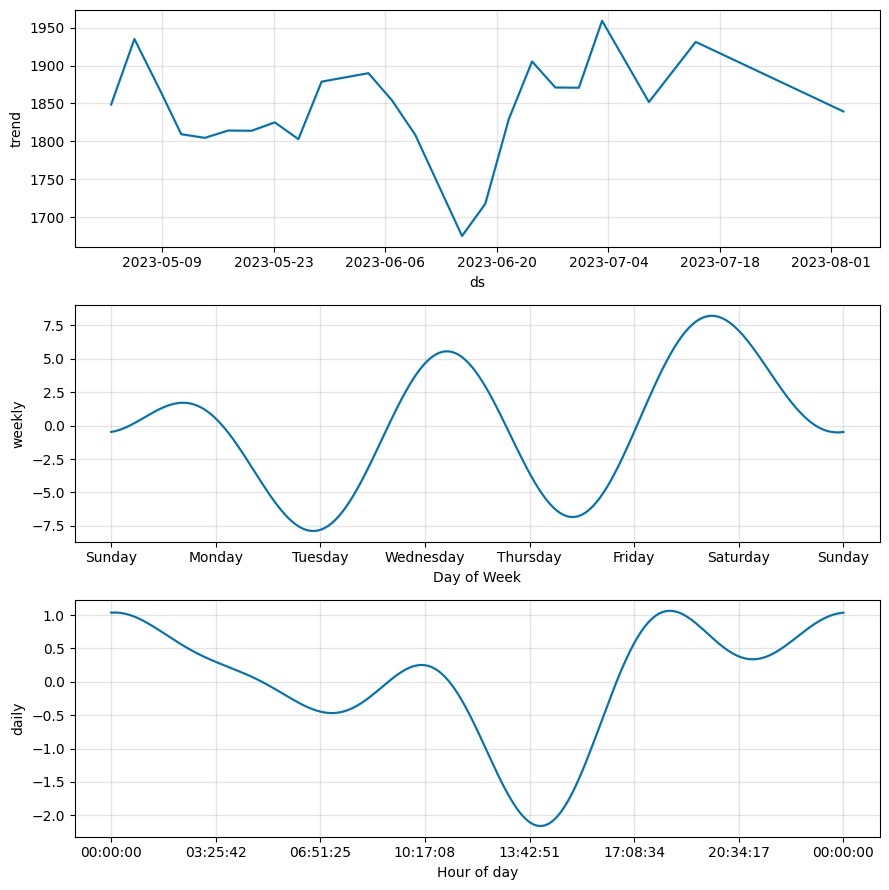

In [28]:
m.plot_components(forecast)

<Axes: xlabel='Datetime', ylabel='y'>

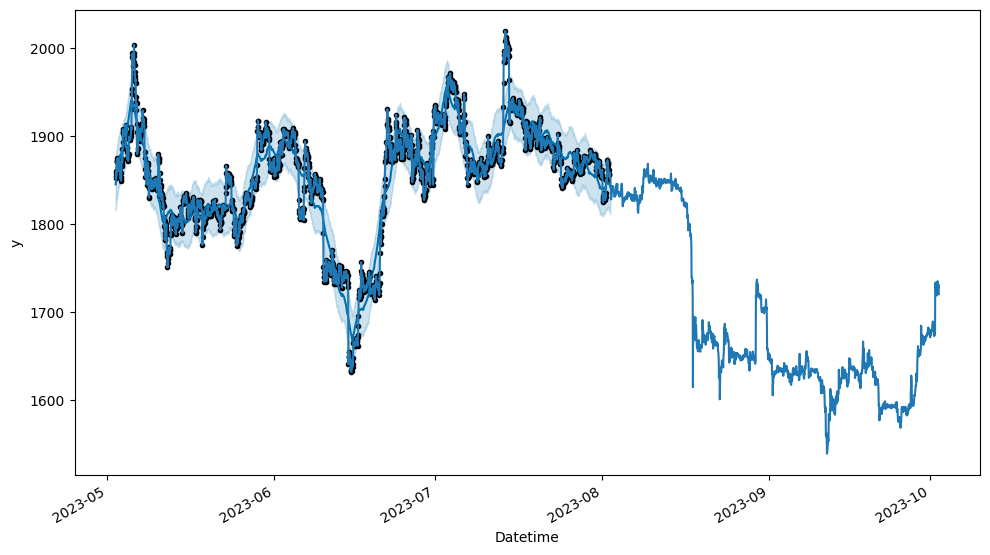

In [29]:
m.plot(forecast[['ds','yhat','yhat_lower','yhat_upper']])
eth.close.plot()

# Parameter Tuning

In [57]:

p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'holidays_prior_scale':[3,4,5,6,7],
          'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0

for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 250
